<a href="https://colab.research.google.com/github/BahruzHuseynov/Object-Tracking-AI_Lab/blob/main/Models/FineTunedBest_YOLOv8%2BDeepSORT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Kaggle and video dataset

In [1]:
!pip install -q kaggle
!kaggle datasets download hbahruz/multiple-lego-tracking-dataset

Dataset URL: https://www.kaggle.com/datasets/hbahruz/multiple-lego-tracking-dataset
License(s): other
100% 1.48G/1.48G [00:23<00:00, 145MB/s]
100% 1.48G/1.48G [00:23<00:00, 68.3MB/s]


In [2]:
import zipfile

def extract_zip(file_path, extract_to='.'):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

extract_zip('multiple-lego-tracking-dataset.zip', 'lego-tracking')

## Install libraries

In [3]:
!pip install ultralytics deep_sort_realtime
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 79.9 MB/s eta 0:00:00


## Import libraries

In [4]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import re
import torch

### Test usage of the detection model


image 1/1 /content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/img1/frame0079.jpg: 384x640 3 class_0s, 64.9ms
Speed: 13.9ms preprocess, 64.9ms inference, 1659.1ms postprocess per image at shape (1, 3, 384, 640)
Confidence: 0.97
Confidence: 0.97
Confidence: 0.96


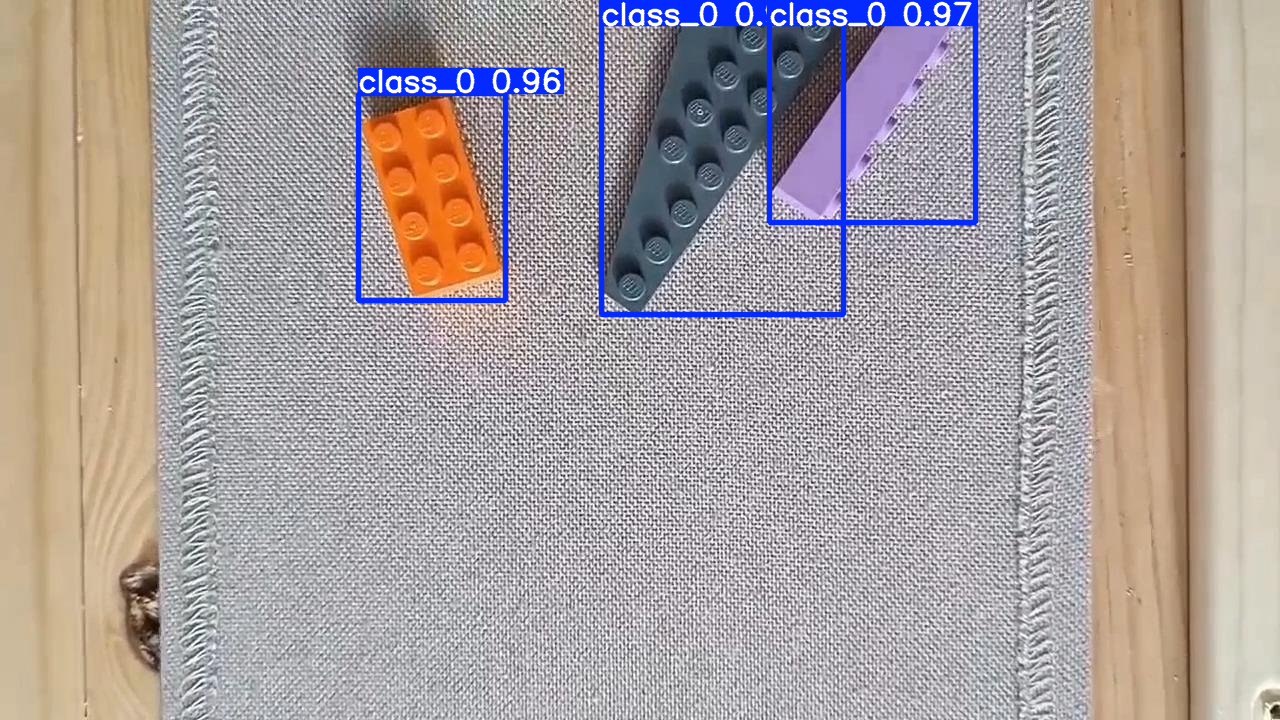

In [6]:
path_yolo_pt = "lego-tracking/Best_YOLOv8_PT_parameters/Best_YOLOv8_PT_parameters/"
model_ft = YOLO(path_yolo_pt + "best.pt")  # or '+ last.pt' for development

img_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/img1"
example = os.path.join(img_path, "frame0079.jpg")
res = model_ft(example)

detections = res[0]

for box in detections.boxes:
    conf = box.conf[0]  # Get the confidence score
    print(f"Confidence: {conf:.2f}")

rgb_array = cv2.cvtColor(res[0].plot(), cv2.COLOR_BGR2RGB)
image = Image.fromarray(rgb_array)
im = image.convert("RGB")
im

## Test Video Results

In [13]:
base_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test"
test_videos = os.listdir(base_path)
test_videos.sort()
test_videos

['Lego1', 'Lego2']

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [15]:
def detect_and_track(train_video, model, tracker, pred_conf, fps = 20.0):
    video_frames = os.path.join(base_path, f"{train_video}/img1")

    ###################### To record the video
    first_frame_path = os.path.join(video_frames, 'frame0001.jpg')
    first_frame = cv2.imread(first_frame_path)
    frame_height, frame_width = first_frame.shape[:2]

    video_output = os.path.join('/content/', f'{train_video}_tracked.mp4')
    video_writer = cv2.VideoWriter(video_output, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    ######################

    tracking_results = []
    unique_track_ids = set()
    frames = os.listdir(video_frames)
    frame_pattern = re.compile(r'frame(\d+)\.jpg')
    frames_sorted = sorted(frames, key=lambda x: int(frame_pattern.match(x).group(1)))

    tracker_initialized = False
    for frame_id, frame_name in enumerate(frames_sorted):
        frame_path = os.path.join(video_frames, frame_name)
        frame = cv2.imread(frame_path)

        result_frame = model(frame, conf=pred_conf)
        detections = result_frame[0].boxes.xywh.tolist()
        confidences = result_frame[0].boxes.conf.tolist()


        # Prepare detections in the format required by DeepSort
        formatted_detections = []
        for (x_center, y_center, width, height), conf in zip(detections, confidences):
            left = x_center - width / 2
            top = y_center - height / 2
            formatted_detections.append(([left, top, width, height], conf, 0))

        if not tracker_initialized and len(formatted_detections) > 0:
            tracker_initialized = True
        if len(formatted_detections) > 0:
            tracks = tracker.update_tracks(formatted_detections, frame=frame)
        else:
            tracks = []
        current_frame_object_count = 0

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            current_frame_object_count += 1
            unique_track_ids.add(track_id)
            tracking_results.append([frame_id, int(track_id), x1, y1, x2 - x1, y2 - y1])

        cv2.putText(frame, f"Objects in frame: {current_frame_object_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Unique objects: {len(unique_track_ids)}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        video_writer.write(frame)

    video_writer.release()
    return tracking_results

In [19]:
path_yolo_pt = "lego-tracking/Best_YOLOv8_PT_parameters/Best_YOLOv8_PT_parameters/"
model = YOLO(path_yolo_pt + "best.pt").to(device)
test_frames = [20, 25]

tracking_results_dict = {}
for test_video, test_frame in zip(test_videos, test_frames):
    print(5*"-------------------------------------------------------------------------------------------------------\n")
    print(test_video)
    tracker = DeepSort(max_age=10, n_init=3, nms_max_overlap=1.0)
    test_res = detect_and_track(test_video, model, tracker, 0.25, float(test_frame))
    tracking_results_dict[test_video] = test_res

Streaming output truncated to the last 5000 lines.
Speed: 2.3ms preprocess, 21.1ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 class_0s, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 10.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 class_0s, 30.3ms
Speed: 2.1ms preprocess, 30.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 class_0s, 19.0ms
Speed: 4.6ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 class_0s, 22.5ms
Speed: 5.8ms preprocess, 22.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 class_0s, 18.0ms
Speed: 2.2ms preprocess, 18.0ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 class_0s, 21.3ms
Speed: 1.9ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 class_0s, 23.1ms
Speed: 6.9ms preprocess, 23.1ms inference, 1.9ms pos

## Metrics

In [17]:
!pip install motmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 6.8 MB/s eta 0:00:00


In [18]:
import motmetrics as mm

In [20]:
def load_ground_truth(gt_file):
    ground_truths = []
    with open(gt_file, 'r') as file:
        for line in file:
            parts = list(map(float, line.strip().split(',')))
            frame_id, obj_id, x, y, width, height = int(parts[0]), int(parts[1]), parts[2], parts[3], parts[4], parts[5]
            ground_truths.append([frame_id, obj_id, x, y, width, height])
    return np.array(ground_truths)

In [21]:
def evaluate_tracking(ground_truths, tracking_results):
    def results_to_motchallenge_format(results):
        return np.array([[r[0], -1, r[2], r[3], r[4], r[5], 1, -1, -1, -1] for r in results])

    gt_mot = results_to_motchallenge_format(ground_truths)
    tr_mot = results_to_motchallenge_format(tracking_results)

    acc = mm.MOTAccumulator(auto_id=True)

    gt_dict = {frame_id: [] for frame_id in np.unique(ground_truths[:, 0])}
    for gt in gt_mot:
        gt_dict[gt[0]].append(gt[1:])

    tr_dict = {frame_id: [] for frame_id in np.unique(tracking_results[:, 0])}
    for tr in tr_mot:
        tr_dict[tr[0]].append(tr[1:])

    for frame_id in gt_dict.keys():
        gt_frame = gt_dict[frame_id]
        tr_frame = tr_dict.get(frame_id, [])

        gt_ids = [gt[0] for gt in gt_frame]
        tr_ids = [tr[0] for tr in tr_frame]

        gt_bboxes = np.array([gt[1:5] for gt in gt_frame])
        tr_bboxes = np.array([tr[1:5] for tr in tr_frame])

        distances = mm.distances.iou_matrix(gt_bboxes, tr_bboxes, max_iou=1)

        acc.update(gt_ids, tr_ids, distances)

    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches'])

    strsummary = mm.io.render_summary(summary, formatters=mh.formatters)
    print(strsummary)

    return summary

#### Test Check

In [22]:
z = load_ground_truth("/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego2/gt.txt")
sm = evaluate_tracking(z, np.array(tracking_results_dict["Lego2"]))
sm

   mota  motp    idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches
0 93.2% 0.575 1054.3%  94.7%     98.4%       12601       11938                 197        663            0


,mota,motp,idf1,recall,precision,num_objects,num_matches,num_false_positives,num_misses,num_switches
0,0.931751,0.574748,10.542933,0.947385,0.983766,12601,11938,197,663,0


## Results

In [26]:
def aggregate_metrics(gt_files, tracking_results_dict):
    overall_acc = mm.MOTAccumulator(auto_id=True)

    dct = {}
    metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches']

    for gt_file, track_key in zip(gt_files, tracking_results_dict):
        print(gt_file, track_key)
        ground_truths = load_ground_truth(gt_file)
        tr_mot = np.array(tracking_results_dict[track_key])

        et = evaluate_tracking(ground_truths, tr_mot)
        for metric in metrics:
            dct[metric] = dct.get(metric, 0) + et[metric]


    for metric in metrics:
        dct[metric] /= len(gt_files)
    return pd.DataFrame(dct)

In [28]:
main_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test"
gt_files = [os.path.join(main_path, vid, "gt.txt") for vid in os.listdir(main_path)]
gt_files.sort()
gt_files

['/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/gt.txt',
 '/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego2/gt.txt']

In [29]:
sorted_dict = dict(sorted(tracking_results_dict.items()))
print(sorted_dict)

{'Lego1': [[20, 1, 610, 0, 59, 33], [21, 1, 604, 0, 69, 38], [22, 1, 600, 0, 81, 45], [22, 2, 409, 0, 112, 33], [23, 1, 597, 0, 90, 50], [23, 2, 401, 0, 129, 39], [24, 1, 594, 0, 101, 57], [24, 2, 391, 0, 147, 45], [25, 1, 593, 0, 108, 62], [25, 2, 386, 0, 158, 49], [26, 1, 591, 0, 114, 68], [26, 2, 377, 0, 172, 55], [27, 1, 590, 0, 117, 71], [27, 2, 374, 0, 176, 58], [28, 1, 589, 0, 122, 76], [28, 2, 368, 0, 186, 63], [29, 1, 589, 0, 125, 79], [29, 2, 366, 0, 189, 66], [30, 1, 590, 0, 128, 83], [30, 2, 361, 0, 196, 71], [31, 1, 590, 0, 131, 87], [31, 2, 359, 0, 198, 74], [32, 1, 590, 0, 136, 92], [32, 2, 357, 0, 203, 79], [33, 1, 590, 0, 140, 97], [33, 2, 355, 0, 206, 83], [34, 1, 589, 0, 146, 103], [34, 2, 350, 0, 212, 90], [35, 1, 589, 0, 150, 109], [35, 2, 347, 0, 217, 95], [36, 1, 588, 0, 155, 116], [36, 2, 342, 0, 223, 103], [36, 3, 789, 0, 67, 26], [37, 1, 589, 0, 156, 120], [37, 2, 341, 0, 222, 107], [37, 3, 782, 0, 75, 29], [38, 1, 588, 0, 162, 127], [38, 2, 339, 0, 224, 112],

In [30]:
aggregate_metrics(gt_files, sorted_dict) # (max_age=10, n_init=5, nms_max_overlap=1.0)

/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/gt.txt Lego1
   mota  motp   idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches
0 95.1% 0.890 903.9%  98.8%     96.4%       10628       10496                 392        132            0
/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego2/gt.txt Lego2
   mota  motp    idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches
0 93.2% 0.575 1054.3%  94.7%     98.4%       12601       11938                 197        663            0


,mota,motp,idf1,recall,precision,num_objects,num_matches,num_false_positives,num_misses,num_switches
0,0.941224,0.73242,9.791173,0.967483,0.973882,11614.5,11217.0,294.5,397.5,0.0


## Train Video Results
####  Same steps are applied for training but the folders and files correctly must be defined

In [31]:
path_yolo_pt = "lego-tracking/Best_YOLOv8_PT_parameters/Best_YOLOv8_PT_parameters/"
model_ft = YOLO(path_yolo_pt + "best.pt").to(device)

In [32]:
base_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Train"
train_videos = os.listdir(base_path)
train_videos.sort()
train_videos = train_videos[:1] + train_videos[2:] + train_videos[1:2]
train_videos

['Lego1',
 'Lego2',
 'Lego3',
 'Lego4',
 'Lego5',
 'Lego6',
 'Lego7',
 'Lego8',
 'Lego9',
 'Lego10']

In [ ]:
path_yolo_pt = "lego-tracking/Best_YOLOv8_PT_parameters/Best_YOLOv8_PT_parameters/"
model = YOLO(path_yolo_pt + "best.pt").to(device)
train_frames = [16, 13, 20, 20, 21, 20, 15, 13, 19, 20]

tracking_results_dict = {}
for train_video, train_frame in zip(train_videos, train_frames):
    print(5*"-------------------------------------------------------------------------------------------------------\n")
    print(train_video)
    tracker = DeepSort(max_age=20, n_init=5, nms_max_overlap=0.8)
    tr_res = detect_and_track(train_video, model, tracker, 0.25, float(train_frame))
    tracking_results_dict[train_video] = tr_res

In [ ]:
main_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Train"
gt_files = [os.path.join(main_path, vid, "gt.txt") for vid in os.listdir(main_path)]
gt_files.sort()
gt_files

In [ ]:
sorted_dict = dict(sorted(tracking_results_dict.items()))
print(sorted_dict)

In [ ]:
aggregate_metrics(gt_files, sorted_dict) # (max_age=10, n_init=5, nms_max_overlap=1.0)